In [12]:
pip install surprise

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-macosx_11_0_arm64.whl size=441434 sha256=966069e0e2967503e86fc11a2e39a4add605891c68467ecb218aaedd402a1e45
  Stored in directory: /Users/songmin-ui/Library/Caches/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


### 0. Kaggle을 통해 data 가져오기

In [5]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("ehallmar/beers-breweries-and-beer-reviews")

#print("Path to dataset files:", path)

100%|████████████████████████████████████████| 810M/810M [00:33<00:00, 25.2MB/s]

Extracting files...


Path to dataset files: /Users/songmin-ui/.cache/kagglehub/datasets/ehallmar/beers-breweries-and-beer-reviews/versions/2


### 1. 필요 라이브러리 설치 및 data 확인

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import KFold as SurpriseKFold
from sklearn.cluster import KMeans

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
path="C:/Users/K/MachineLearning/Beer-Recommender-System"

In [5]:
file_list = os.listdir(path)
print(file_list)

['.git', '.gitignore', '.ipynb_checkpoints', 'beers.csv', 'breweries.csv', 'EDA+Preprocess', 'Hybrid', 'ML_TermProject.ipynb', 'README.md', 'reviews.csv']


In [6]:
beer = os.path.join(path, 'beers.csv')
breweries = os.path.join(path, 'breweries.csv')
reviews = os.path.join(path, 'reviews.csv')

In [7]:
beer_df = pd.read_csv(beer)
breweries_df = pd.read_csv(breweries)
reviews_df = pd.read_csv(reviews)

In [8]:
print("\n--- Beer DataFrame Columns ---")
print(beer_df.columns)

print("\n--- Breweries DataFrame Columns ---")
print(breweries_df.columns)

print("\n--- Reviews DataFrame Columns ---")
print(reviews_df.columns)


--- Beer DataFrame Columns ---
Index(['id', 'name', 'brewery_id', 'state', 'country', 'style', 'availability',
       'abv', 'notes', 'retired'],
      dtype='object')

--- Breweries DataFrame Columns ---
Index(['id', 'name', 'city', 'state', 'country', 'notes', 'types'], dtype='object')

--- Reviews DataFrame Columns ---
Index(['beer_id', 'username', 'date', 'text', 'look', 'smell', 'taste', 'feel',
       'overall', 'score'],
      dtype='object')


In [9]:
print("--- Beer DataFrame Info (Data Types) ---")
beer_df.info()

print("\n--- Breweries DataFrame Info (Data Types) ---")
breweries_df.info()

print("\n--- Reviews DataFrame Info (Data Types) ---")
reviews_df.info()

--- Beer DataFrame Info (Data Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358873 entries, 0 to 358872
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            358873 non-null  int64  
 1   name          358873 non-null  object 
 2   brewery_id    358873 non-null  int64  
 3   state         298147 non-null  object 
 4   country       358719 non-null  object 
 5   style         358872 non-null  object 
 6   availability  358873 non-null  object 
 7   abv           320076 non-null  float64
 8   notes         358827 non-null  object 
 9   retired       358873 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.4+ MB

--- Breweries DataFrame Info (Data Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50347 entries, 0 to 50346
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50347 non-null

In [7]:
print(f"Beer DataFrame: {beer_df.head()}")

Beer DataFrame:        id                                  name  brewery_id state country  \
0  202522                        Olde Cogitator        2199    CA      US   
1   82352  Konrads Stout Russian Imperial Stout       18604   NaN      NO   
2  214879                        Scottish Right       44306    IN      US   
3  320009               MegaMeow Imperial Stout        4378    WA      US   
4  246438                       Peaches-N-Cream       44617    PA      US   

                     style availability   abv                   notes retired  
0    English Oatmeal Stout     Rotating   7.3  No notes at this time.       f  
1   Russian Imperial Stout     Rotating  10.4  No notes at this time.       f  
2             Scottish Ale   Year-round   4.0  No notes at this time.       t  
3  American Imperial Stout       Winter   8.7    Every time this year       f  
4       American Cream Ale     Rotating   5.1  No notes at this time.       f  


In [8]:
print(f"Breweries DataFrame: {breweries_df.head()}")

Breweries DataFrame:       id                                  name            city state country  \
0  19730                       Brouwerij Danny       Erpe-Mere   NaN      BE   
1  32541           Coachella Valley Brewing Co  Thousand Palms    CA      US   
2  44736                      Beef 'O' Brady's      Plant City    FL      US   
3  23372                Broadway Wine Merchant   Oklahoma City    OK      US   
4  35328  Brighton Beer Dispensary (DUPLICATE)        Brighton   GB2      GB   

                                               notes                     types  
0                             No notes at this time.                   Brewery  
1                             No notes at this time.  Brewery, Bar, Beer-to-go  
2                             No notes at this time.               Bar, Eatery  
3                             No notes at this time.                     Store  
4  Duplicate of https://www.beeradvocate.com/beer...               Bar, Eatery  


In [9]:
print(f"Reviews DataFrame: {reviews_df.head()}")

Reviews DataFrame:    beer_id         username        date  \
0   271781     bluejacket74  2017-03-17   
1   125646          _dirty_  2017-12-21   
2   125646          CJDUBYA  2017-12-21   
3   125646  GratefulBeerGuy  2017-12-20   
4   125646         LukeGude  2017-12-20   

                                                text  look  smell  taste  \
0     750 ml bottle, 2016 vintage, bottle #304 of...  4.00   4.00   4.00   
1                                                     4.50   4.50   4.50   
2                                                     4.75   4.75   4.75   
3     0% 16 oz can. Funny story: As I finally wal...  4.75   4.75   4.50   
4     Classic TH NEIPA. Overflowing head and bouq...  4.25   4.50   4.25   

   feel  overall  score  
0  4.25     4.00   4.03  
1  4.50     4.50   4.50  
2  4.75     4.75   4.75  
3  4.50     4.50   4.58  
4  4.25     4.25   4.31  


# 2. EDA

### (1)reviews_df

--- 'score' describe ---
count    9.073128e+06
mean     3.889815e+00
std      6.127417e-01
min      1.000000e+00
25%      3.570000e+00
50%      4.000000e+00
75%      4.250000e+00
max      5.000000e+00
Name: score, dtype: float64


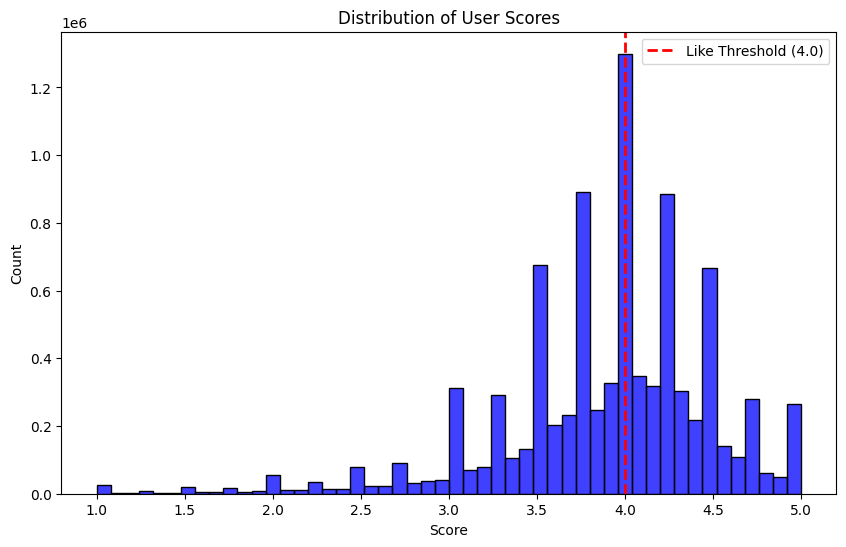


--- 'is_like' (Target Variable) Class Balance ---
is_like
1    0.52745
0    0.47255
Name: proportion, dtype: float64


In [10]:
print("--- 'score' describe ---")
print(reviews_df['score'].describe())

# Score Distribution Visualization
plt.figure(figsize=(10, 6))
sns.histplot(reviews_df['score'], bins=50, kde=False, color='blue')
plt.title('Distribution of User Scores')
plt.xlabel('Score')
plt.ylabel('Count')
# Add a vertical line at the threshold (4.0)
plt.axvline(x=4.0, color='red', linestyle='--', linewidth=2, label='Like Threshold (4.0)')
plt.legend()
plt.show()

# Create Target Variable 'is_like' based on the threshold
# Proposal defines 'Like' as score >= 4.0
reviews_df['is_like'] = (reviews_df['score'] >= 4.0).astype(int)

# Check Class Balance
class_balance = reviews_df['is_like'].value_counts(normalize=True)
print("\n--- 'is_like' (Target Variable) Class Balance ---")
print(class_balance)

In [11]:
# --- Check Data Scale and Sparsity ---

# Get the number of unique users
n_users = reviews_df['username'].nunique()
# Get the number of unique items (beers) that have at least one review
n_items = reviews_df['beer_id'].nunique()
# Get the total number of reviews
n_reviews = len(reviews_df)

print(f"Total Reviews (N): {n_reviews:,}")
print(f"Total Unique Users (U): {n_users:,}")
print(f"Total Unique Items (Beers) with Reviews (I): {n_items:,}")

# Calculate the sparsity of the user-item matrix
# Sparsity = 1 - (Number of Interactions / Total Possible Interactions)
sparsity = 1 - (n_reviews / (n_users * n_items))
print(f"User-Item Matrix Sparsity: {sparsity:.6%}")


# --- Analyze User and Item Activity ---

# Get review counts per user
user_activity = reviews_df['username'].value_counts()
print("\n--- User Activity (Reviews per User) Stats ---")
# Get descriptive statistics for user activity
print(user_activity.describe(percentiles=[.1, .25, .5, .75, .9, .99]))

# Get review counts per item (beer)
item_activity = reviews_df['beer_id'].value_counts()
print("\n--- Item Activity (Reviews per Beer) Stats ---")
# Get descriptive statistics for item activity
print(item_activity.describe(percentiles=[.1, .25, .5, .75, .9, .99]))

Total Reviews (N): 9,073,128
Total Unique Users (U): 164,934
Total Unique Items (Beers) with Reviews (I): 309,542
User-Item Matrix Sparsity: 99.982228%

--- User Activity (Reviews per User) Stats ---
count    164934.000000
mean         54.987528
std         270.564806
min           1.000000
10%           1.000000
25%           1.000000
50%           3.000000
75%          15.000000
90%          85.000000
99%        1061.000000
max       13798.000000
Name: count, dtype: float64

--- Item Activity (Reviews per Beer) Stats ---
count    309542.000000
mean         29.311460
std         227.138758
min           1.000000
10%           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
90%          31.000000
99%         502.000000
max       17160.000000
Name: count, dtype: float64


### (2)beer_df

In [12]:
# Check for missing values in the 'style' column
print(f"Style Missing values: {beer_df['style'].isnull().sum()}")

# Calculate the number of unique values in 'style'
n_styles = beer_df['style'].nunique()
print(f"Total unique beer styles: {n_styles}")

# Check the Top 20 most common styles
print("\n--- Top 20 Most Common Beer Styles ---")
print(beer_df['style'].value_counts().head(20))

# Check how many styles are very rare (e.g., appeared < 10 times)
rare_styles_count = (beer_df['style'].value_counts() < 10).sum()
print(f"\nNumber of rare styles (appearing < 10 times): {rare_styles_count}")

# Calculate the proportion of rare styles out of all unique styles
rare_styles_proportion = rare_styles_count / n_styles
print(f"Proportion of rare styles: {rare_styles_proportion:.2%}")

Style Missing values: 1
Total unique beer styles: 112

--- Top 20 Most Common Beer Styles ---
style
American IPA                  44719
American Pale Ale (APA)       22159
American Imperial IPA         18338
Belgian Saison                18167
American Wild Ale             12972
American Imperial Stout       11180
American Porter               10168
American Amber / Red Ale       9748
American Stout                 9103
Fruit and Field Beer           7729
American Blonde Ale            7089
American Brown Ale             7008
German Hefeweizen              6020
Belgian Witbier                5613
American Pale Wheat Ale        5266
Berliner Weisse                5036
German Pilsner                 4748
Belgian Pale Ale               4523
Russian Imperial Stout         4426
English Sweet / Milk Stout     4192
Name: count, dtype: int64

Number of rare styles (appearing < 10 times): 1
Proportion of rare styles: 0.89%


ABV Missing values: 38797

--- ABV Descriptive Statistics ---
count    320076.000000
mean          6.528504
std           2.085403
min           0.010000
50%           6.000000
95%          10.500000
99%          13.000000
max         100.000000
Name: abv, dtype: float64


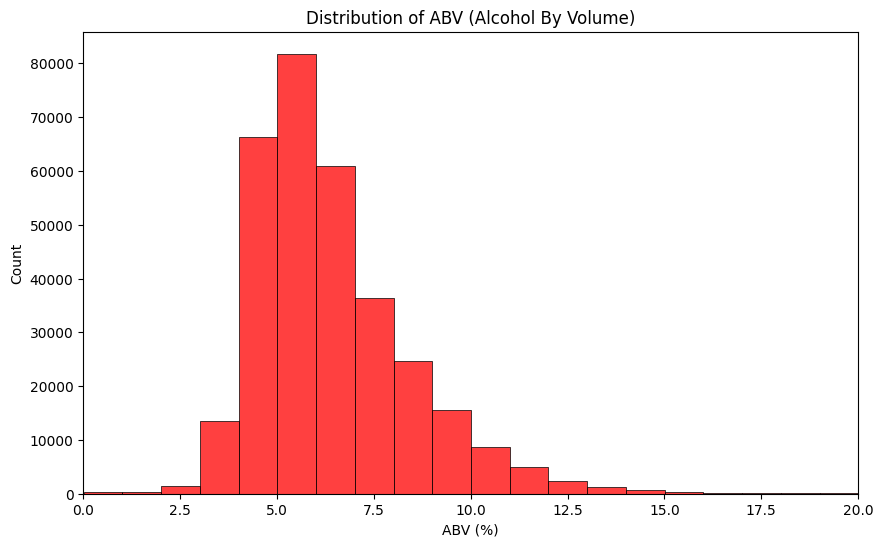

In [12]:
# Check the number of missing values in the 'abv' column
print(f"ABV Missing values: {beer_df['abv'].isnull().sum()}")

# Get descriptive statistics for 'abv' to check distribution and outliers (max)
print("\n--- ABV Descriptive Statistics ---")
print(beer_df['abv'].describe(percentiles=[.95, .99]))

# Visualize the 'abv' distribution (Histogram)
# Most beers are under 20%, so we limit the x-axis (xlim) to 0-20 to see the distribution clearly
plt.figure(figsize=(10, 6))
sns.histplot(beer_df['abv'].dropna(), bins=100, kde=False, color='red')
plt.title('Distribution of ABV (Alcohol By Volume)')
plt.xlabel('ABV (%)')
plt.ylabel('Count')
plt.xlim(0, 20) # Limit range to 0-20% to exclude extreme outliers and see detail
plt.show()

## 3. Preprocessing

### (1) Filtering

In [13]:
print(f"--- 1. Filtering ---")
print(f"Original reviews_df shape: {reviews_df.shape}")
print(f"Original beer_df shape: {beer_df.shape}")

# --- Step 1: Filter Items (min 5 reviews per beer) ---
# Calculate review counts for each beer_id
item_counts = reviews_df['beer_id'].value_counts()
active_items = item_counts[item_counts >= 5].index
# Keep only the reviews that belong to these active items
reviews_df_filtered = reviews_df[reviews_df['beer_id'].isin(active_items)]

print(f"\nAfter Item Filtering (min 5 reviews/item): {reviews_df_filtered.shape}")

# --- Step 2: Filter Users (min 10 reviews per user) ---
# (Using the already item-filtered data) recalculate user counts
user_counts = reviews_df_filtered['username'].value_counts()
active_users = user_counts[user_counts >= 10].index
# Keep only the reviews that belong to these active users
reviews_df_filtered = reviews_df_filtered[reviews_df_filtered['username'].isin(active_users)]

print(f"After User Filtering (min 10 reviews/user): {reviews_df_filtered.shape}")

# --- Step 3: Filter beer_df (keep only active beers) ---
# For K-Means clustering and merging,
# keep only the beers in beer_df that are present in the final filtered review list.
final_active_items = reviews_df_filtered['beer_id'].unique()
beer_df_filtered = beer_df[beer_df['id'].isin(final_active_items)]

print(f"\nFiltered beer_df shape: {beer_df_filtered.shape}")

--- 1. Filtering ---
Original reviews_df shape: (9073128, 11)
Original beer_df shape: (358873, 10)

After Item Filtering (min 5 reviews/item): (8716321, 11)
After User Filtering (min 10 reviews/user): (8417229, 11)

Filtered beer_df shape: (112159, 10)


### (2) Mering

In [14]:
print(f"--- 2. Merging DataFrames ---")

# --- Step 1: Merge Item (Beer) + Brewery Info ---
# For K-Means and CB, merge the filtered beer info (beer_df_filtered), with the brewery info (breweries_df).
# Use a 'left' join to keep all beers from 'beer_df_filtered'.
item_metadata_df = pd.merge(
    beer_df_filtered,
    breweries_df,
    how='left',
    left_on='brewery_id',
    right_on='id',
    suffixes=('_beer', '_brewery') # Distinguish overlapping column names (id, name, etc.)
)

print(f"Item + Brewery metadata shape: {item_metadata_df.shape}")

# --- Step 2: Merge Reviews + Item Info (Create Master Data) ---
# Merge the filtered reviews (reviews_df_filtered) with the merged item metadata (item_metadata_df).
# Use an 'inner' join to keep only data present in both tables.
df_master = pd.merge(
    reviews_df_filtered,
    item_metadata_df,
    how='inner',
    left_on='beer_id',
    right_on='id_beer' # The beer id column from item_metadata_df
)

print(f"Final Master DataFrame shape: {df_master.shape}")

# --- Step 3: Clean up unnecessary columns ---
# Tidy up duplicate or redundant ID/name columns.
df_master = df_master.drop(columns=[
    'id_beer', # Redundant with beer_id
    'id_brewery' # Redundant with brewery_id
])

print(f"Final Master DataFrame shape after cleanup: {df_master.shape}")
print("\n--- Master DataFrame Head ---")
print(df_master.head())

--- 2. Merging DataFrames ---
Item + Brewery metadata shape: (112159, 17)
Final Master DataFrame shape: (8417033, 28)
Final Master DataFrame shape after cleanup: (8417033, 26)

--- Master DataFrame Head ---
   beer_id         username        date  \
0   271781     bluejacket74  2017-03-17   
1   125646          _dirty_  2017-12-21   
2   125646  GratefulBeerGuy  2017-12-20   
3   125646         LukeGude  2017-12-20   
4   125646          jneff33  2017-12-20   

                                                text  look  smell  taste  \
0     750 ml bottle, 2016 vintage, bottle #304 of...  4.00   4.00   4.00   
1                                                     4.50   4.50   4.50   
2     0% 16 oz can. Funny story: As I finally wal...  4.75   4.75   4.50   
3     Classic TH NEIPA. Overflowing head and bouq...  4.25   4.50   4.25   
4                                                     4.50   4.75   5.00   

   feel  overall  score  is_like                   name_beer  brewery_id  \
0

### (3) Missing value imputation

In [15]:
print(f"--- 3. Missing Value Imputation ---")

# --- Step 1: Impute 'abv' (Alcohol By Volume) ---
print(f"Original 'abv' missing count: {df_master['abv'].isnull().sum()}")

# 1-1. Calculate the median 'abv' for each 'style'.
# .transform('median') maps the median of its style back to each row.
style_median_abv = df_master.groupby('style')['abv'].transform('median')

# Fill NaN values with the median 'abv' of their respective 'style'.
df_master['abv'] = df_master['abv'].fillna(style_median_abv)

# 1-2. If any 'style' itself had all NaN 'abv' values, fill the remaining NaNs with the global 'abv' median.
global_median_abv = df_master['abv'].median()
df_master['abv'] = df_master['abv'].fillna(global_median_abv)

print(f"New 'abv' missing count: {df_master['abv'].isnull().sum()}")


# --- Step 2: Impute other features for K-Means/Hybrid ---
# Fill categorical 'object' type features with 'Unknown'.
print(f"\nOriginal 'state_brewery' missing: {df_master['state_brewery'].isnull().sum()}")
print(f"Original 'city' missing: {df_master['city'].isnull().sum()}")
print(f"Original 'types' missing: {df_master['types'].isnull().sum()}")

# Batch fill 'object' type NaNs with 'Unknown'
cols_to_fill_unknown = ['state_brewery', 'city', 'types']
for col in cols_to_fill_unknown:
    df_master[col] = df_master[col].fillna('Unknown')

print(f"New 'state_brewery' missing: {df_master['state_brewery'].isnull().sum()}")

--- 3. Missing Value Imputation ---
Original 'abv' missing count: 125428
New 'abv' missing count: 0

Original 'state_brewery' missing: 1026019
Original 'city' missing: 33354
Original 'types' missing: 0
New 'state_brewery' missing: 0


### (4) Feature Engineering

In [16]:
print("--- Feature Engineering for K-Means ---")

# --- Step 1: Extract unique beer data for K-Means ---
kmeans_features = ['beer_id', 'style', 'abv', 'types', 'country_brewery']
beer_features_df = df_master[kmeans_features].drop_duplicates(subset=['beer_id']).set_index('beer_id')

print(f"Unique item features extracted. Shape: {beer_features_df.shape}")

# --- Step 2: Group 'style' into 'style_group' ---
def group_style(style):
    if 'IPA' in style: return 'IPA'
    if 'Stout' in style: return 'Stout'
    if 'Ale' in style: return 'Ale' # Pale Ale, Amber Ale, Brown Ale...
    if 'Lager' in style or 'Pilsner' in style or 'Hefeweizen' in style: return 'Lager/Wheat'
    if 'Saison' in style or 'Belgian' in style or 'Witbier' in style: return 'Belgian/Saison'
    if 'Wild Ale' in style or 'Berliner Weisse' in style: return 'Sour/Wild'
    return 'Other' # Porter, Fruit Beer, etc.

beer_features_df['style_group'] = beer_features_df['style'].apply(group_style)
print("\nStyle groups created:")
print(beer_features_df['style_group'].value_counts())

# --- Step 3: Group 'country_brewery' into 'geo_group' ---
def group_country(country):
    if country == 'US': return 'US'
    if country in ['DE', 'GB', 'BE', 'DK', 'NL', 'NO', 'IT', 'SE', 'CZ']: return 'Europe'
    if country == 'CA': return 'Canada'
    return 'Other' # Asia, South America, etc.

beer_features_df['geo_group'] = beer_features_df['country_brewery'].apply(group_country)
print("\nGeo groups created:")
print(beer_features_df['geo_group'].value_counts())

# --- Step 4: Drop original columns ---
# Drop the original columns that are no longer needed for K-Means
beer_features_df = beer_features_df.drop(columns=['style', 'country_brewery', 'types'])

print("\nFeature Engineering complete. Final features for K-Means:")
print(beer_features_df.head())

--- Feature Engineering for K-Means ---
Unique item features extracted. Shape: (112159, 4)

Style groups created:
style_group
Ale               31152
IPA               24678
Other             23459
Stout             12583
Belgian/Saison    10424
Lager/Wheat        8216
Sour/Wild          1647
Name: count, dtype: int64

Geo groups created:
geo_group
US        88826
Europe    10888
Canada     6609
Other      5836
Name: count, dtype: int64

Feature Engineering complete. Final features for K-Means:
          abv style_group geo_group
beer_id                            
271781   10.8       Stout        US
125646    8.2         IPA        US
205644    6.5         Ale        US
150672    7.0         IPA    Canada
311190    8.0       Stout        US


### (5) Encoding & Scaling

In [17]:
print("--- Encoding & Scaling (for K-Means) ---")

# --- Step 1: Define Preprocessing Pipeline ---
# Define which columns are numerical and which are categorical

# Numerical features to be scaled
numeric_features = ['abv']
# Categorical features to be One-Hot Encoded
categorical_features = ['style_group', 'geo_group']

# Create the preprocessing pipeline
# This will apply StandardScaler to numeric features
# and OneHotEncoder to categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# --- Step 2: Apply the preprocessing ---
# Fit and transform the new beer_features_df
# The output (beer_features_processed) will be a dense numpy array
# ready for K-Means.
beer_features_processed = preprocessor.fit_transform(beer_features_df)

# Get the names of the new encoded features (for interpretability)
feature_names = preprocessor.get_feature_names_out()

print(f"\nPreprocessing complete.")
print(f"Shape of processed data (for K-Means): {beer_features_processed.shape}")
print(f"Total features created: {len(feature_names)}")
print("This data is now ready for K-Means clustering.")

--- Encoding & Scaling (for K-Means) ---

Preprocessing complete.
Shape of processed data (for K-Means): (112159, 12)
Total features created: 12
This data is now ready for K-Means clustering.


### (6) K-means

--- Finding Optimal K (Elbow Method) ---
Running Elbow Method to find optimal K...
Plotting Elbow Method graph...


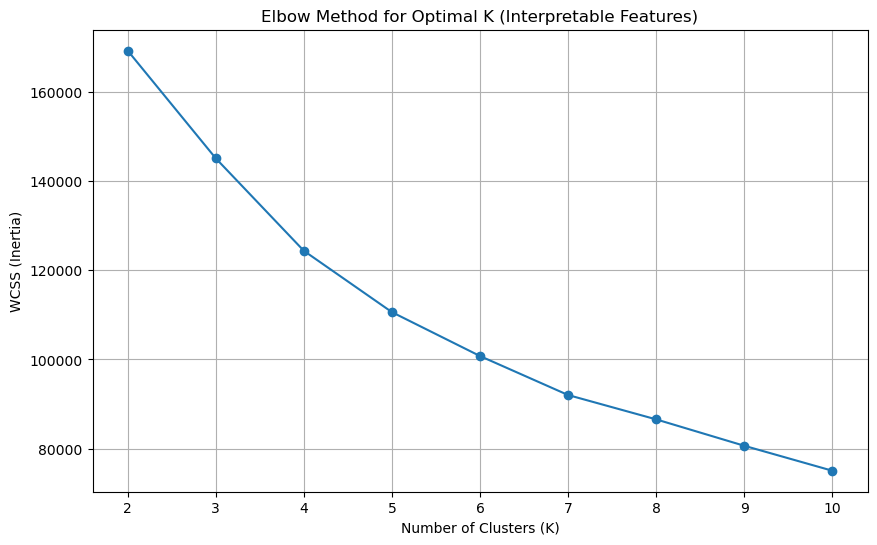

In [149]:
print("--- 6. (FINAL) K-Means Clustering ---")

# --- Find Optimal K (Elbow Method) ---
print("Running Elbow Method to find optimal K...")
wcss = []
k_values = range(2, 11) # Check K from 2 to 10

# 12 features on 112k data
for k in k_values:
    kmeans_test = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_test.fit(beer_features_processed)
    wcss.append(kmeans_test.inertia_)

# Plot the Elbow graph
print("Plotting Elbow Method graph...")
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal K (Interpretable Features)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [165]:
# Based on the elbow graph, K=6 is the optimal "elbow" point.
OPTIMAL_K = 6 

print(f"\nFitting final K-Means model with K={OPTIMAL_K} (on FULL data)...")
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)

# Fit the model and predict the cluster (0-5) for each of the 112k beers
cluster_labels = kmeans.fit_predict(beer_features_processed)

# 1. Add the cluster labels as a new column to beer_features_df
print("Adding 'cluster' column to beer_features_df...")
beer_features_df['cluster'] = cluster_labels 

# Define the 3 columns we want to add to the main df_master
columns_to_merge = ['cluster', 'style_group', 'geo_group'] 

# Merge the new features (cluster, style_group, geo_group) into df_master
print("Merging new features into df_master...")
df_master = df_master.merge(
    beer_features_df[columns_to_merge], # Get the 3 columns
    left_on='beer_id',
    right_index=True, # beer_features_df is indexed by beer_id
    how='left'
)

print("K-Means complete. All new features added to df_master.")
print(f"Total reviews in df_master: {len(df_master)}")

# Check the head of the updated df_master
print("--- Head of df_master with new features ---")
print(df_master[['beer_id', 'style_group', 'geo_group', 'cluster']].head())


Fitting final K-Means model with K=6 (on FULL data)...
Adding 'cluster' column to beer_features_df...
Merging new features into df_master...
K-Means complete. All new features added to df_master.
Total reviews in df_master: 8417033
--- Head of df_master with new features ---
   beer_id style_group geo_group  cluster
0   271781       Stout        US        1
1   125646         IPA        US        2
2   125646         IPA        US        2
3   125646         IPA        US        2
4   125646         IPA        US        2


In [169]:
print("\n--- Analyzing Cluster Meanings ---")

# Group the 112k beer_features_df by the new cluster label
cluster_analysis = beer_features_df.groupby('cluster')

# Calculate the size (count) and average ABV for each cluster
cluster_summary = cluster_analysis['abv'].agg(['count', 'mean']).sort_values(by='count', ascending=False)

# Find the most common (mode) style_group and geo_group for each cluster
cluster_summary['top_style_group'] = cluster_analysis['style_group'].apply(lambda x: x.mode()[0])
cluster_summary['top_geo_group'] = cluster_analysis['geo_group'].apply(lambda x: x.mode()[0])

print("Cluster Interpretation Summary:")
print(cluster_summary)


--- Analyzing Cluster Meanings ---
Cluster Interpretation Summary:
         count       mean top_style_group top_geo_group
cluster                                                
4        21889   5.926326             Ale            US
2        21709   7.250780             IPA            US
3        18881   5.522496             Ale        Europe
1        17840  10.647040           Stout            US
5        17300   5.712635  Belgian/Saison            US
0        14540   5.906644           Other            US


In [24]:
output_filename = 'df_master_preprocessed.csv'

print(f"Saving df_master to '{output_filename}'...")
print(f"This may take several minutes as the file is large ({len(df_master)} rows).")

# df_master를 CSV 파일로 저장합니다.
# index=False는 0, 1, 2... 같은 행 인덱스를 파일에 저장하지 않아 용량을 줄여줍니다.
df_master.to_parquet(output_filename, index=False)

print(f"Successfully saved to '{output_filename}'.")

Saving df_master to 'df_master_preprocessed.csv'...
This may take several minutes as the file is large (8417033 rows).


ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
!pip install pyarrow

In [28]:
!pip install fastparquet

   ---------------------------------------- 0.0/670.7 kB ? eta -:--:--
   ---------------------------------------- 670.7/670.7 kB 13.2 MB/s  0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.6 MB/s  0:00:00

   -------------------- ------------------- 1/2 [fastparquet]
   ---------------------------------------- 2/2 [fastparquet]



In [29]:
# [수정됨] output_filename의 확장자를 .parquet으로 변경
output_filename = 'df_master_preprocessed.parquet'

print(f"Saving df_master to '{output_filename}'...")
print(f"This may take several minutes as the file is large ({len(df_master)} rows).")

# df_master를 Parquet 파일로 저장합니다.
# [수정됨] engine을 'pyarrow' 대신 'fastparquet'로 변경
df_master.to_parquet(output_filename, engine='fastparquet', index=False)

print(f"Successfully saved to '{output_filename}'.")
print(f"File size should now be much smaller than 6.4GB CSV.")

Saving df_master to 'df_master_preprocessed.parquet'...
This may take several minutes as the file is large (8417033 rows).
Successfully saved to 'df_master_preprocessed.parquet'.
File size should now be much smaller than 6.4GB CSV.
